
##SCC5809 - REDES NEURAIS ARTIFICIAIS E APRENDIZADO PROFUNDO
##**SCC - ICMC - USP**
Profa. Roseli Ap. Francelin Romero </br>
2o. sem. de 2021 </br>
**Exercício de Rede GAN usando CNNs ** nos módulos:

modelo Discriminador
modelo Generativo 
para geração de imagens (conjunto MNIST)

# Exercício Prático - GAN

---------------------------------------------

### Grupo 3

### Participantes:
 - Francielle Vargas - 9527629
 - Lucas Nunes Sequeira - 9009642
 - Emanuel Huber - 12110113

#### Data: 03/11/2021





## Setup

In [1]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(420)
np.random.seed(420)

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-k0c8p2vk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-k0c8p2vk
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157864 sha256=014a91f8808225680bed668c341e0683d2467996a7097386bee3a84505e93c26
  Stored in directory: /tmp/pip-ephem-wheel-cache-4rz5h0z3/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Carregando e pré-processando o dataset

Será utilizado o dataset MNIST para que seja treinado o modelo gerador e o discriminador.

In [4]:
# Carregando o dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Concatenate data
all_images = np.concatenate((train_images, test_images), axis=0)

11501568/11490434 [==============================] - 0s 0us/step


Em passos futuros, vamos utilizar de ruídos aleatórios dados por uma distribuição normal entre [-1, 1]. Portanto, temos que nosso dataset também deve ser normalizado dessa maneira. Como temos imagens de 8 bits (valores de 0 a 255), vamos utilzar metade do valor total, isto é, 127.5, para normalizarmos os dados. Temos, portanto, a seguinte normalização: $$ \frac{x - 127.5}{127.5} $$
Percebemos que se substituirmos os valores de máximo e mínimo (0 e 255), teremos como resultado, respectivamente, -1 e 1. 

In [5]:
# Normalizando o dataset
all_images = all_images.reshape(all_images.shape[0], 28, 28, 1).astype('float32')
all_images = (all_images - 127.5) / 127.5

In [6]:
# Variáveis para embaralharmos o dataset e separarmos em batches
BUFFER_SIZE = 70000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Criação dos modelos

Ambos modelos gerador e discriminador são definidos utilizando um modelo sequencial do framework - [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### Modelo Gerador

O modelo gerador utiliza de uma seed aleatória para fazer a imagem. `tf.keras.layers.Conv2DTranspose` faz essa construção. Ao final, devemos obter uma imagem 28x28x1.
Faça um modelo gerador utilizando `tf.keras.Sequential` com os seguintes critérios:
- Para cada camada, utilize o parâmetro  `use_bias=False`.
- Utilize Batch Normalization após cada camada (não necessária na de saída)
- Utilize a função Leaky ReLU como ativação.
- Utilize tanh como função de ativação da última camada.
Siga a seguinte arquitetura:
- Camada densa com $7 \cdot 7 \cdot 256$ com entrada (100,). A entrada será um seed (ruído aleatório) para servir de base para a construção da imagem. Escolhemos essa saída para conseguirmos gerar ao final facilmente uma imagem (28, 28, 1).
- Camada de `Conv2DTranspose` para construir uma imagem. Ela deve possuir 128 filtros (5, 5) aplicando zero-padding.
- Camada de `Conv2DTranspose` para construir uma imagem. Ela deve possuir 64 filtros (5, 5) aplicando zero-padding com stride de (2, 2).
- Camada de saída `Conv2DTranspose` para construir a imagem final. Ela deve possui 1 saída com filtro (5, 5) aplicando zero-padding com stride de (2, 2).


In [8]:
def modelo_gerador(latent_dim = 100):

  # Input Layer
  inputs = layers.Input((latent_dim,))
  
  # Dense layer
  x = layers.Dense(7 * 7 * 256, use_bias=False)(inputs)
  x = layers.Reshape((7, 7, 256))(x)
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  # Convolutional Block 1
  x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), use_bias=False, padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  # Convolutional Block 2
  x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), use_bias=False, padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  # Convolutional Block 3 (Output)
  outputs = layers.Conv2DTranspose(1, (5, 5), use_bias=False, activation="tanh", padding='same')(x)

  # Build model
  model = tf.keras.Model(inputs, outputs, name="Gerador")
  model.build(input_shape=(latent_dim,))

  return model

In [9]:
def modelo_gerador(latent_dim = 100, n_classes = 10):

  # Input Layer
  inputs = layers.Input((latent_dim,))
  
  # Dense layer
  x = layers.Dense(7 * 7 * (latent_dim + n_classes), use_bias=False)(inputs)
  x = layers.Reshape((7, 7, latent_dim + n_classes))(x)

  class_trigger = x[:, :, :, latent_dim:]
  x = x[:, :, :, :latent_dim]

  # Normalization
  x = layers.LeakyReLU()(x)
  x = layers.BatchNormalization()(x)

  # Gate Class Trigger
  class_trigger = layers.Activation('tanh')(class_trigger)

  # Conv Loop # (n, n, k) -> (2n, 2n, 32)
  for i in range(2):

      # Residual Block
      residual = x
      residual = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), use_bias=True, padding='same')(residual)
      residual = layers.LeakyReLU()(residual)
      residual = layers.BatchNormalization()(residual)

      # Class trigger block
      class_trigger = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), use_bias=True, padding='same')(class_trigger)
      class_trigger = layers.Activation('tanh')(class_trigger)

      # Convolutional Block 1
      x = layers.Conv2DTranspose(96, (5, 5), strides=(1, 1), use_bias=False, padding='same')(x)
      x = layers.LeakyReLU()(x)
      x = layers.BatchNormalization()(x)

      # Convolutional Block 2
      x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), use_bias=False, padding='same')(x)
      x = layers.LeakyReLU()(x)
      x = layers.BatchNormalization()(x)

      # Add residual
      x = layers.add([residual, x])
      x = layers.BatchNormalization()(x)

      # Trigger Class
      x = layers.multiply([x, class_trigger])
      x = layers.BatchNormalization()(x)

  # Convolutional Output # (28, 28, 32) -> (28, 28, 1) (and scaling to (-1, 1) with tanh)
  outputs = layers.Conv2DTranspose(1, (5, 5), use_bias=False, padding='same', activation="tanh")(x)

  # Build model
  model = tf.keras.Model(inputs, outputs, name="Gerador")
  model.build(input_shape=(latent_dim,))

  return model

Usando o modelo gerador sem treinamento

Model: "Gerador"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 5390)         539000      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 7, 7, 110)    0           ['dense[0][0]']                  
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 7, 7, 100)   0           ['reshape[0][0]']                
 icingOpLambda)                                                                             

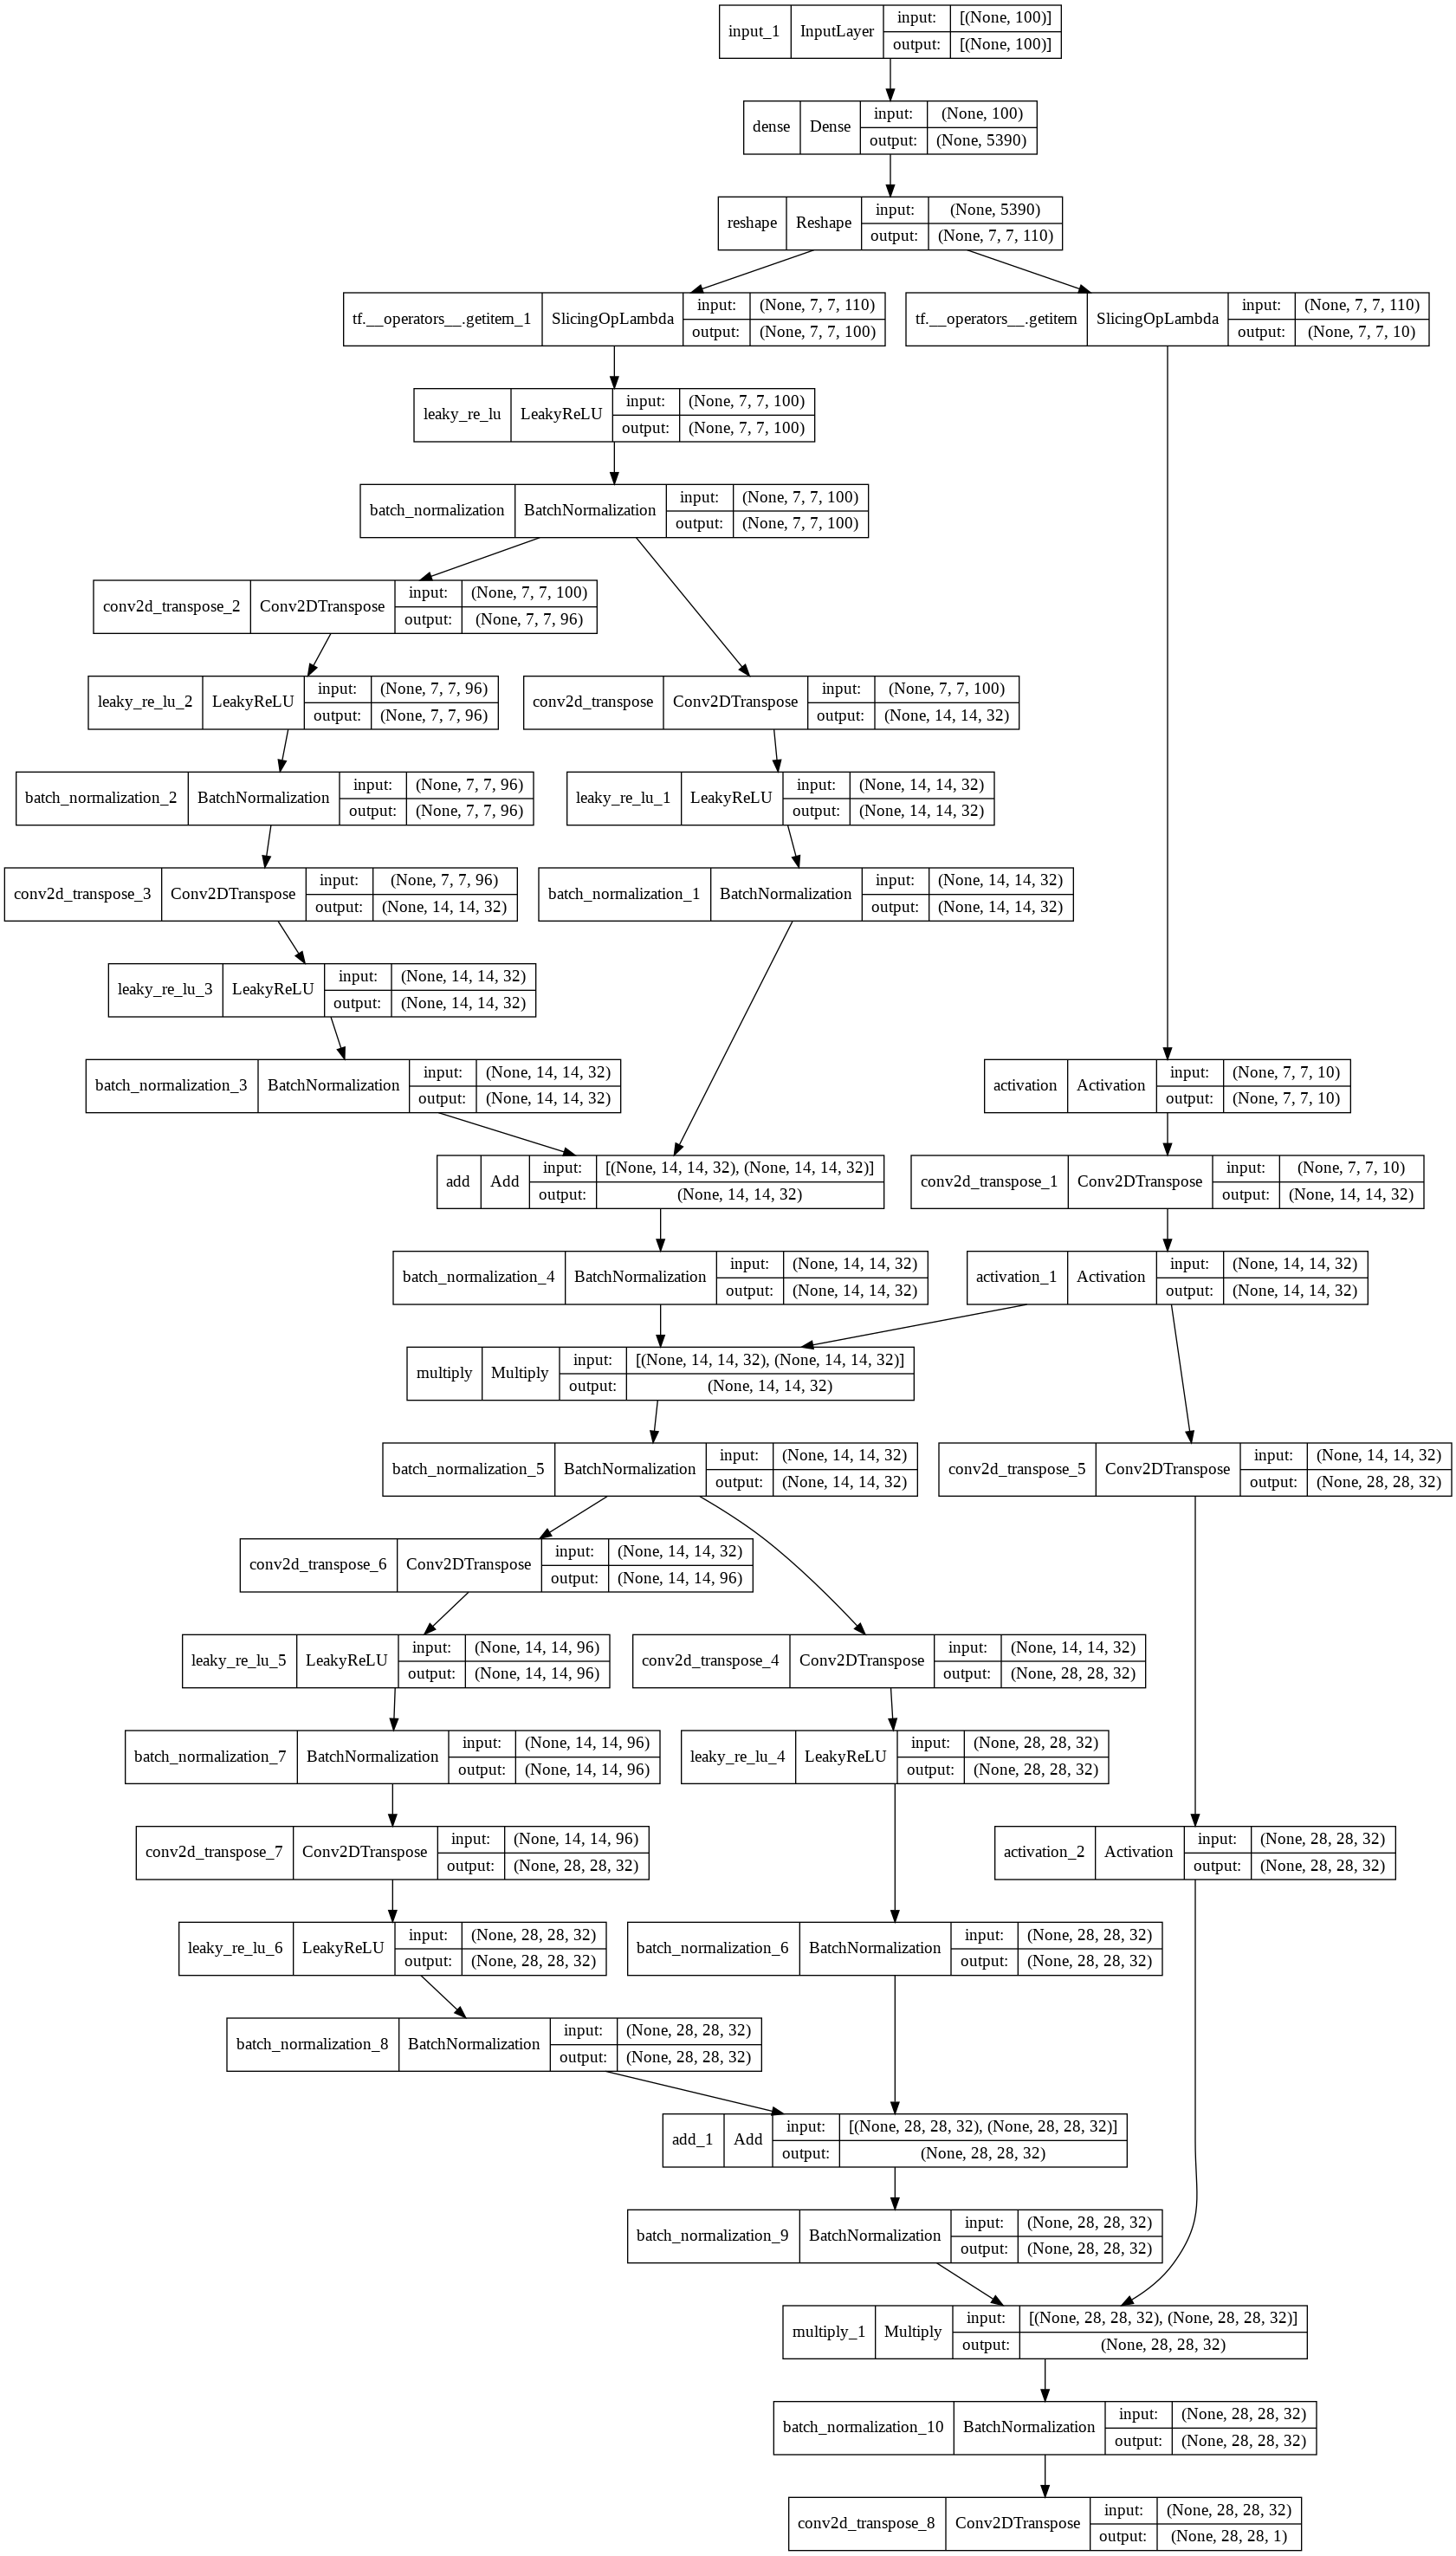

In [10]:
latent_dim = 100
gerador = modelo_gerador(latent_dim=latent_dim)
gerador.summary()
tf.keras.utils.plot_model(gerador, show_shapes=True)

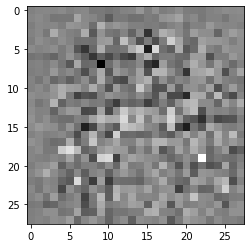

In [11]:
seed = tf.random.normal([1, latent_dim])
imagem_gerada = gerador(seed, training=False)

_ = plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

### Modelo Discriminador

O modelo discriminador consiste em um classificador de imagem baseado em uma rede neural convolucional.

Na função abaixo, declare um modelo sequencial do keras (`tf.keras.Sequential`) com as seguintes camadas:
- Camada convolucional de input $28 \times 28 \times 1$ (dimensão de cada imagem), com 64 filtros de tamanho $5\times5$, stride de 2 e zero-padding (`padding = 'same'`)
- Função de ativação não linear leaky ReLU
- Dropout com $p = 0.3$
- Camada convolucional com 128 filtros de tamanho $5\times5$, stride de 2 e zero-padding
- Função de ativação não linear leaky ReLU
- Dropout com $p=0.3$
- Flatten dos mapas de características obtidos
- Camada densa de apenas um neurónio

In [12]:
def modelo_discriminador():
  # Input Layer
  inputs = layers.Input((28, 28, 1,))
  
  # Convolutional Block 1
  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(rate=0.3)(x)

  # Convolutional Block 2
  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(rate=0.3)(x)

  # Avg. Pooling
  x = layers.GlobalAveragePooling2D()(x)

  # Output Block
  x = layers.Flatten()(x)
  x = layers.LeakyReLU()(x)
  outputs = layers.Dense(1)(x)

  # Build model
  model = tf.keras.Model(inputs, outputs, name="Discriminador")
  model.build(input_shape=(28, 28, 1,))

  return model

In [13]:
def modelo_discriminador():
  # Input Layer
  inputs = layers.Input((28, 28, 1,))
  
  # Convolutional Block 1
  x = layers.Conv2D(64, (5, 5), use_bias=False, padding='same')(inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(rate=0.3)(x)

  # Conv Loop # (2n, 2n, k) -> (n, n, 32)
  for i in range(2):

    # Residual Block
    residual = x
    residual = layers.Conv2D(32, (5, 5), strides=(2, 2), use_bias=True, padding='same')(residual)
    residual = layers.LeakyReLU()(residual)
    residual = layers.BatchNormalization()(residual)

    # Convolutional Block 2
    x = layers.SeparableConv2D(96, (5, 5), use_bias=False, padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    # Convolutional Block 2
    x = layers.Conv2D(32, (5, 5), use_bias=False, padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)

    # Add residual
    x = layers.add([residual, x])
    x = layers.BatchNormalization()(x)

  # Avg. Pooling
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.LeakyReLU()(x)

  # Output Block
  outputs = layers.Dense(1)(x)

  # Build model
  model = tf.keras.Model(inputs, outputs, name="Discriminador")
  model.build(input_shape=(28, 28, 1,))

  return model

Uma vez com os modelos gerador e discriminador em mãos (e ainda não treinados), podemos classificar as imagens geradas como reais ou falsas.

Iremos treinar o modelo de forma que o resultado positivo indique imagens reais, enquanto valores negativos indiquem imagens falsas.

Model: "Discriminador"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   1600        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)      (None, 28, 28, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 28, 28, 64)   0           ['leaky_re_lu_7[0][0]']          
                                                                                      

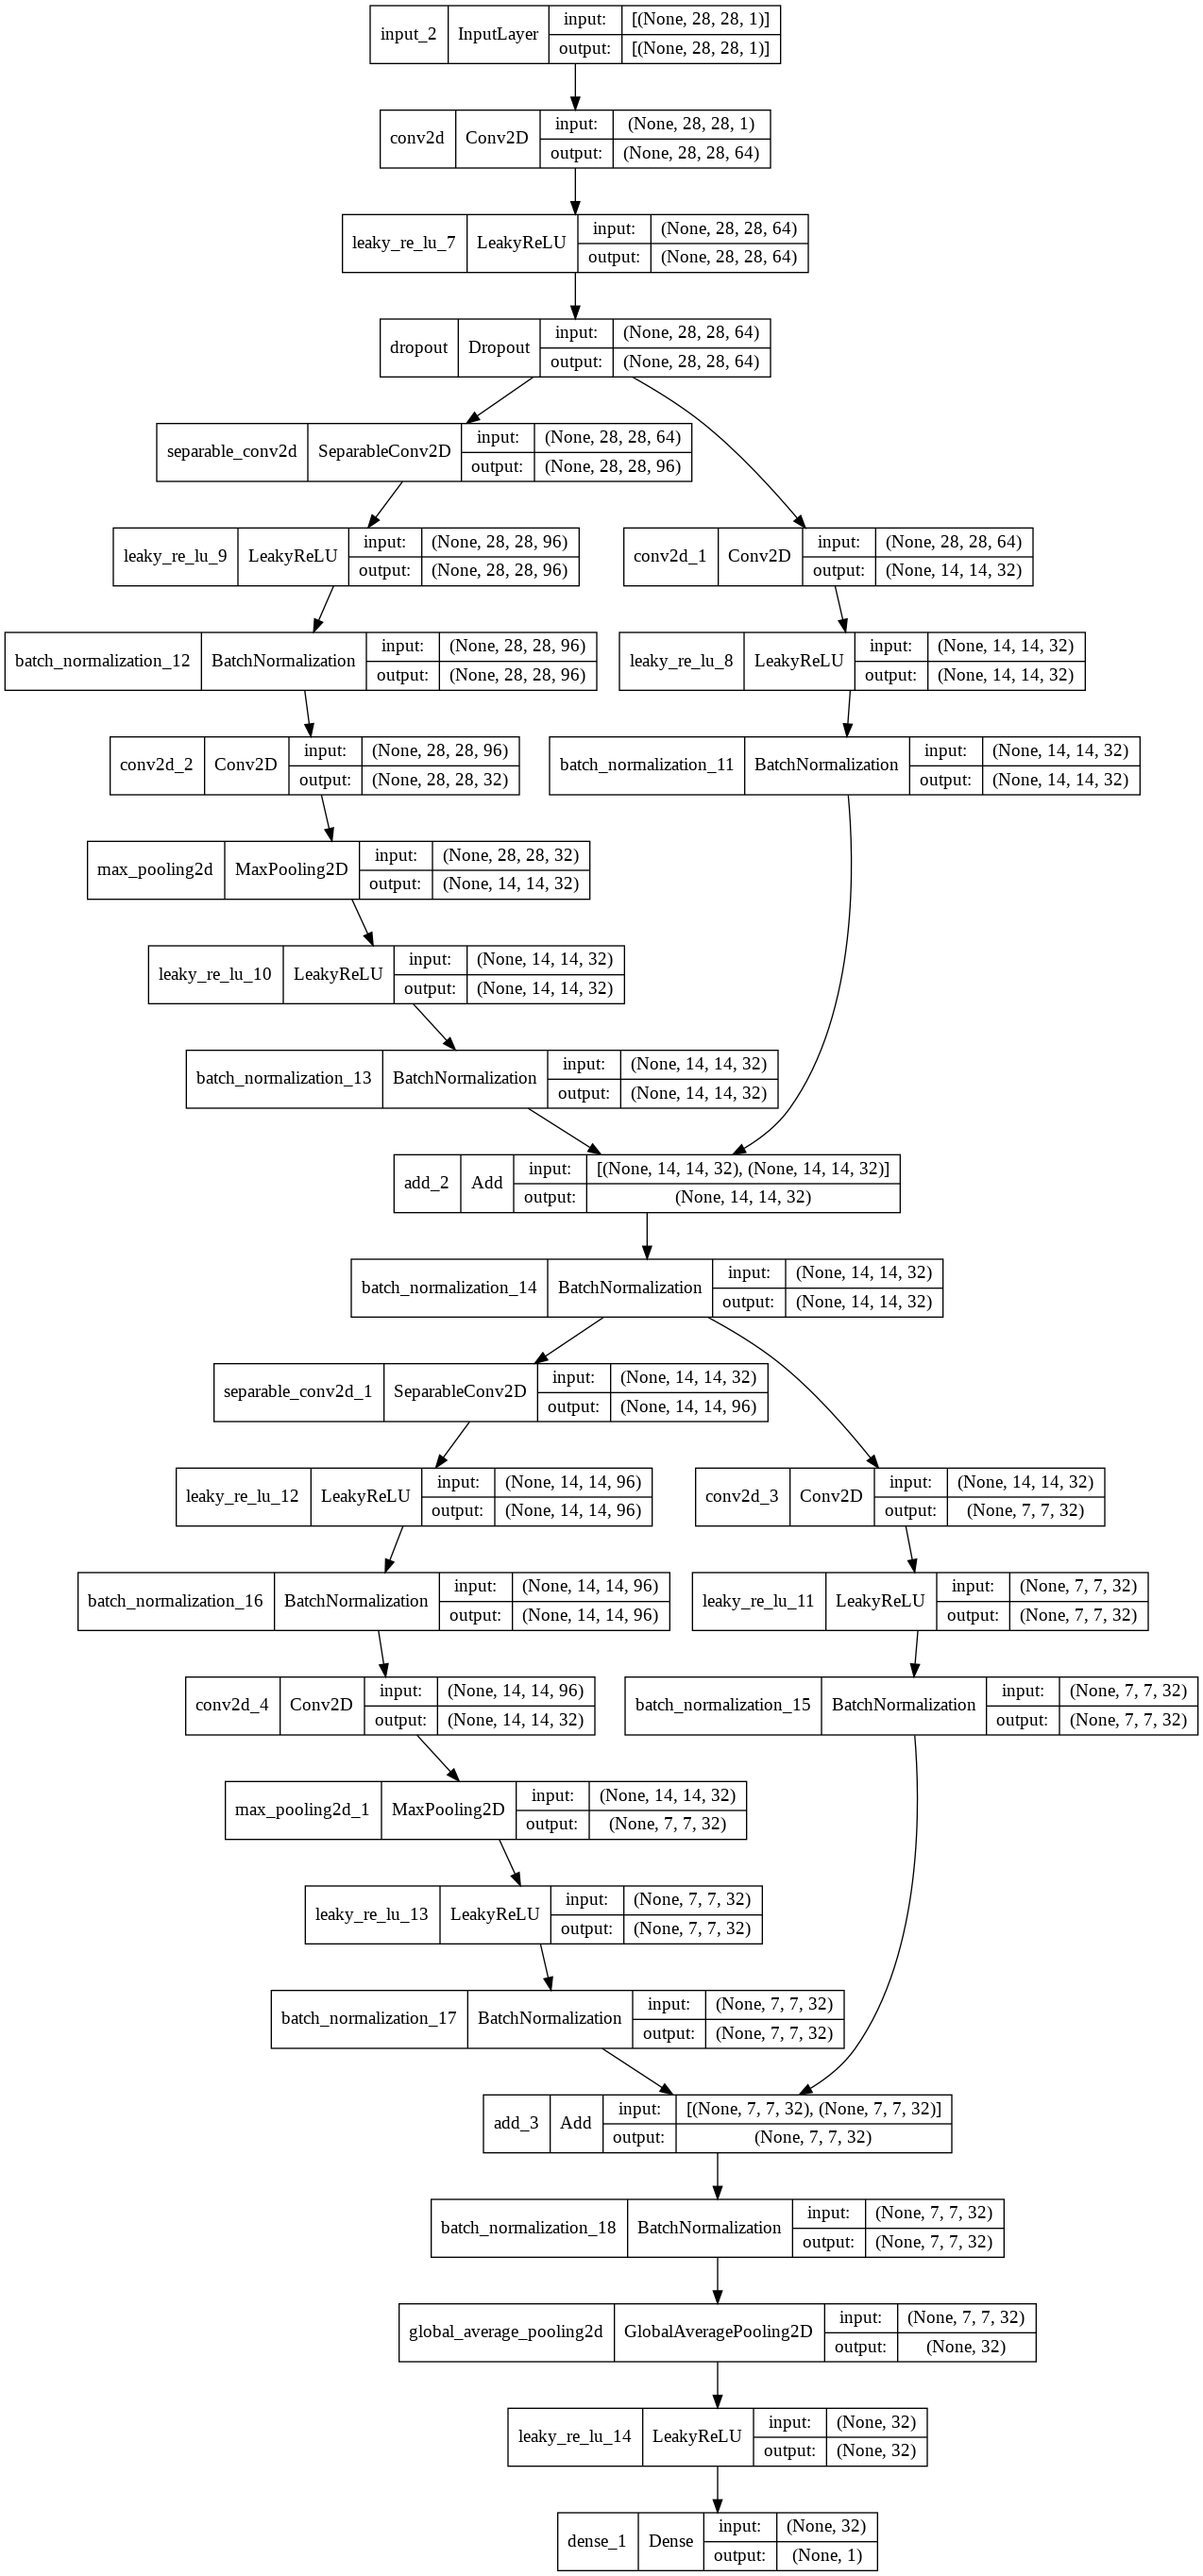

In [14]:
discriminador = modelo_discriminador()
discriminador.summary()
tf.keras.utils.plot_model(discriminador, show_shapes=True)

In [15]:
decision = discriminador(imagem_gerada)
print(decision)

tf.Tensor([[4.0254454e-06]], shape=(1, 1), dtype=float32)


## Definindo a função de custo e otimizadores

Agora, devemos definir as funções de custo e quais serão os otimizadores para ambos os modelos para que possa ocorrer o treinamento.

In [16]:
# Função de entropia cruzada para cálculo da loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Com a função abaixo devemos quantificar quão bem o discriminador classifica as imagens reais e/ou imagens falsas.

Para isso, devemos comparar as predições do discriminador para as imagens reais ao array de uns e as predições do discriminador em imagens falsas, criadas pelo nosso modelo gerador, com um array de valores zeros.

Na função, atribua à `fake_loss` a entropia cruzada do output em cima de imagens criadas pelo modelo gerador em relação ao array de valores zeros.

In [17]:
def discriminador_loss(real_output, fake_output):
    
    # Concatenate data
    concat_output = tf.concat([real_output, fake_output], axis=0)
    concat_labels = tf.concat([tf.ones_like(real_output), tf.zeros_like(fake_output)], axis=0)

    # Calculate loss
    loss = cross_entropy(concat_labels, concat_output) 

    return loss

### Generator loss

A função de custo do modelo gerador é quantificada a partir do quão confuso foi a predição do modelo discriminador. 

Assim, intuitivamente o que temos é que se o modelo gerador é capaz de gerar imagens boas, o discriminador irá classificar imagens falsas (0) como verdadeiras/reais (1), configurando uma baixa loss.

Para realizar a computação desta função de custo, devemos realizar a entropia cruzada entre o array de uns e o array da predição do nosso discriminador para as imagens falsas.

Considerando um array da predição dentro do conjunto de imagens geradas como {0 1 0 1 0 1 0 0 1 0 0 1}, temos 

- Número de imagens falsas classificadas como falsas: 7
- Número de imagens falsas classificadas como reais: 5

Ao realizarmos a entropia cruzada com um vetor {1 1 1 1 1 1 1 1 1 1 1 1}, iremos **penalizar para cada um dos zeros que aparecem**, uma vez que indicam uma classificação certa do modelo discriminador.

In [18]:
def gerador_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Vamos definir os otimizadores para cada modelo

In [19]:
gerador_opt = tf.keras.optimizers.Adam(1e-4)
discriminador_opt = tf.keras.optimizers.Adam(1e-5)

## Loop de treinamento


In [20]:
epocas = 50
seed_dim = 100
n_exemplos = 16
seed = tf.random.normal([n_exemplos, seed_dim])


Temos que o treinamento começa com o **gerador** recebendo uma seed como input e produzindo uma imagem. Após isso, o discriminador é usado para classificar as imagens do dataset original e as produzidas pelo gerador. Calculamos a **função perda (loss)** de cada modelo e seus gradientes.

In [21]:
@tf.function
def step_treino(images):
    seed = tf.random.normal([BATCH_SIZE, seed_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      imagens_geradas = gerador(seed, training=True) # Construindo imagens falsas pelo modelo gerador

      real_output = discriminador(images, training=True) # Previsão do discriminador com imagens reais
      fake_output = discriminador(imagens_geradas, training=True) # Previsão do discriminador com as imagens geradas

      # TODO
      gen_loss = gerador_loss(fake_output) # Calcule a loss do gerador
      disc_loss = discriminador_loss(real_output, fake_output) # Calcule a loss do discriminador

    gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

    gerador_opt.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
    discriminador_opt.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

    return gen_loss, disc_loss

In [22]:
from tqdm.auto import tqdm

def treino(dataset, epocas):

  # Logging
  gen_losses = np.zeros(epocas)
  disc_losses = np.zeros(epocas)

  # Load first epoch
  display.clear_output(wait=True)
  gerar_imagens(gerador, 0, seed)

  for epoca in range(epocas):
    start = time.time()

    # Log progress
    pbar = tqdm(dataset, leave=False)
    pbar.set_description(f'Época {epoca+1}/{epocas}')

    for image_batch in pbar:
      gen_loss, disc_loss = step_treino(image_batch)

      # Enssemble losses
      gen_losses[epoca] = gen_loss.numpy()
      disc_losses[epoca] = disc_loss.numpy()

      pbar.set_postfix({'loss gerador': gen_losses[:epoca+1].mean(), 'loss discriminador': disc_losses[:epoca+1].mean()})

    # Produzindo imagens para formarmos um GIF ao final
    display.clear_output(wait=True)
    gerar_imagens(gerador, epoca + 1, seed)

    print('Tempo de execução para a época {} é {} segundos'.format(epoca + 1, time.time()-start))

  # Salvando imagens para criação do GIF
  display.clear_output(wait=True)
  gerar_imagens(gerador, epocas, seed)

**Função para gerarmos e salvarmos as imagens**


In [23]:
def gerar_imagens(model, epoca, test_input):
  preds = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(preds.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('imagem_epoca_{:04d}.png'.format(epoca))
  plt.show()

## Treinamento

Chamamos agora a função de treino definida acima para treinar simultaneamente os modelos. 

Vamos analisar as imagens geradas cada época.

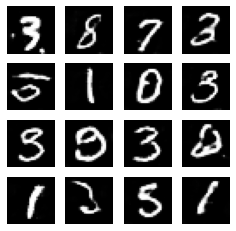

In [24]:
treino(train_dataset, epocas)

## Criando um GIF


In [25]:
def display_image(epoch_no):
  return PIL.Image.open('imagem_epoca_{:04d}.png'.format(epoch_no))

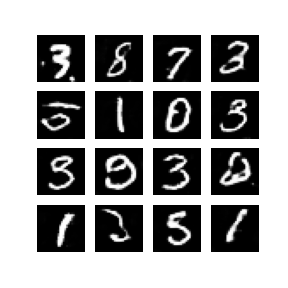

In [26]:
display_image(epocas)

Vamos usar `imageio` para criar um GIF animado a partir das imagens salvas de cada época de treinamento do modelo

In [27]:
def create_gif(filename = 'dcgan.gif', folder = ''):

  with imageio.get_writer(filename, mode='I') as writer:
    filenames = glob.glob(f'{folder}image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

anim_file = 'dcgan.gif'
create_gif(anim_file)

In [28]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

Vamos usar `imageio` para criar um GIF animado perfmormando um caminho aleatório pelo espaço de valores de entrada já com o modelo ajustado

In [29]:
import shutil
from sklearn.preprocessing import minmax_scale

def random_walk(model, latent_dim = 100, steps = 100, noise_amount = 0.1, random_state = 420):

  # Manage dir
  # Clean
  try: shutil.rmtree('random_walk')
  except: pass
  # Create
  try: os.makedirs('random_walk')
  except: pass

  # Set seed
  tf.random.set_seed(random_state)

  # Initial seed
  seed = tf.random.normal((16, latent_dim), dtype='float32')

  # Scaler
  maxval = seed.numpy().max() + noise_amount
  minval = seed.numpy().min() - noise_amount

  # Iterate over amount of steps
  for step in range(steps):

    # Get noise
    noise = tf.random.uniform((16, latent_dim), minval=-noise_amount, maxval=noise_amount)

    # Add noise to seed
    seed += noise

    # Scale seed
    minseed = seed.numpy().min()
    maxseed = seed.numpy().max()

    seed = minmax_scale(seed, feature_range=(max(minval, minseed) , min(maxval, maxseed)), axis=-1)
    seed = tf.convert_to_tensor(seed, dtype='float32')

    # Get predictions
    preds = model(seed, training=False)

    # Clear display
    display.clear_output(wait=True)

    # Plot results
    fig = plt.figure(figsize=(4, 4))

    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('random_walk/image_step_{:04d}.png'.format(step))
    plt.show()

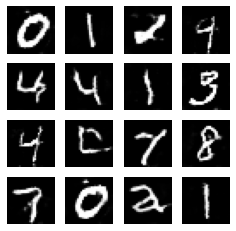

In [30]:
random_walk(gerador, latent_dim = 100, steps = 200, noise_amount = 0.33, random_state = 25)

In [31]:
# Create random walk gif

anim_file = 'random_walk.gif'
create_gif(anim_file, folder='random_walk/')
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.